In [22]:
import tensorflow as tf
import keras
print(keras.__version__)
import pydot
from keras import backend as K
from numba import cuda
import gc
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc
import matplotlib
from keras.models import Sequential, Model, load_model
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.applications.densenet import DenseNet121
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from time import time
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")

2.2.4


#### Data preprocessing

All of the images were sorted into their respective directory folders manually using windows explorer search and drag and drop function.

## Built model

In [23]:
classifier = Sequential()

# First convulutional layer
classifier.add(Convolution2D(32, 3, 3, input_shape = (224, 224, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.2))

# Second convolutional layer
classifier.add(Convolution2D(64, 3, 3))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.2))

#Third convolutional layer
classifier.add(Convolution2D(128,3, 3))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.2))

#Fourth convulutional layer
classifier.add(Convolution2D(256, 3, 3))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.2))


#Flattening, full connection and output = 1 for binary classification
classifier.add(Flatten())
classifier.add(Dense(output_dim = 512, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(output_dim = 1, activation = 'sigmoid'))



# Compile CNN
d = optimizers.Adam(lr=0.0001)
classifier.compile(optimizer = d, loss = 'binary_crossentropy', metrics = ['accuracy'])


# initiate early stopping if no improvement on validation accuracy
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, min_delta=0.01,
                           mode='max', 
                           verbose=1)
#save best model
model_save = ModelCheckpoint('weights.scratch.hdf5', save_best_only=True, monitor='val_acc', mode='max')

#reduce learning rate if no change in validation loss
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, epsilon=1e-4, mode='min')


In [26]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 52, 52, 128)       0         
__________

### Humerus

In [27]:
#Assign model parameters
num_of_valid_samples = 288
num_of_train_samples = 1230
batch_size= 64

#normalize image data, and apply random transformations : height/width shift, horizontal/vertical flip, rotation, and zoom on training
train_datagen_humerus = ImageDataGenerator(rescale = 1./255,
                                           height_shift_range=0.1,
                                           width_shift_range=0.1,
                                           horizontal_flip=True,
                                           rotation_range=45,
                                           zoom_range=0.1)
                
valid_datagen_humerus = ImageDataGenerator(rescale = 1./255)


#set training and validation path
training_set_humerus = train_datagen_humerus.flow_from_directory('C:/Users/arham/Downloads/sorted_train/humerus',
                                                                 target_size = (224, 224),
                                                                 batch_size = batch_size,
                                                                 class_mode = 'binary',classes=['negative', 'positive'])
 
valid_set_humerus = valid_datagen_humerus.flow_from_directory('C:/Users/arham/Downloads/sorted_valid/humerus',
                                            target_size = (224, 224),
                                            batch_size = batch_size, class_mode = 'binary',shuffle=False,classes=['negative', 'positive'])




Found 1230 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


As we have a much smaller dataset compared to our Wrist data, we will be applying random image augmentations in order to artificially create variations in our data in order to improve our results.

In [ ]:
#fit model
hist_humerus = classifier.fit_generator(
        training_set_humerus,
        steps_per_epoch=(num_of_train_samples // batch_size),
        nb_epoch=30,
        validation_data=valid_set_humerus,
        validation_steps=num_of_valid_samples//batch_size,callbacks=[earlyStopping,model_save,reduce_lr_loss])

Epoch 1/30


### Pre-built model

In [4]:
#Assign model parameters
num_of_valid_samples = 288
num_of_train_samples = 1230
batch_size= 16

#normalize image data, and apply random transformations : height/width shift, horizontal/vertical flip, rotation, and zoom on training
train_datagen_humerus = ImageDataGenerator(rescale = 1./255,
                                           height_shift_range=0.1,
                                           width_shift_range=0.1,
                                           horizontal_flip=True,
                                           rotation_range=45,
                                           zoom_range=0.1)
                
valid_datagen_humerus = ImageDataGenerator(rescale = 1./255)


#set training and validation path
training_set_humerus = train_datagen_humerus.flow_from_directory('C:/Users/arham/Downloads/sorted_train/humerus',
                                                                 target_size = (224, 224),
                                                                 batch_size = batch_size,
                                                                 class_mode = 'binary',classes=['negative', 'positive'])
 
valid_set_humerus = valid_datagen_humerus.flow_from_directory('C:/Users/arham/Downloads/sorted_valid/humerus',
                                            target_size = (224, 224),
                                            batch_size = batch_size, class_mode = 'binary',shuffle=False,classes=['negative', 'positive'])




Found 1230 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


we run smaller batches for our pre-trained model due to memory limitations

In [5]:
#import and assign our pre-trained model
densenet_model = DenseNet121(include_top=False, weights='imagenet',  input_shape=(224, 224, 3), pooling='avg')

In [6]:
#define our pre-trained model and add our last dense layer for binary output 1
def build_model():
    base_model = DenseNet121(input_shape=(224, 224,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')

    x = base_model.output
    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [7]:
classifier2 =  build_model()

In [8]:
classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# initiate early stopping if no improvement on validation accuracy
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, min_delta=0.01,
                           mode='max', 
                           verbose=1)
# reduce learning rate by factor of 0.2 if no significant changes 
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [12]:
hist_humerus2 = classifier2.fit_generator(
        training_set_humerus,
        steps_per_epoch=(num_of_train_samples // batch_size),
        nb_epoch=20,
        validation_data=valid_set_humerus,
        validation_steps=num_of_valid_samples//batch_size,callbacks=[earlyStopping,reduce_lr_loss])

Epoch 1/20
76/76 [==============================] - 21s 278ms/step - loss: 0.4519 - acc: 0.8037 - val_loss: 0.4984 - val_acc: 0.7917
Epoch 2/20
76/76 [==============================] - 21s 275ms/step - loss: 0.4401 - acc: 0.8038 - val_loss: 0.4373 - val_acc: 0.8264
Epoch 3/20
76/76 [==============================] - 21s 275ms/step - loss: 0.4344 - acc: 0.8024 - val_loss: 0.4687 - val_acc: 0.8021
Epoch 4/20
76/76 [==============================] - 21s 275ms/step - loss: 0.4155 - acc: 0.8341 - val_loss: 0.4881 - val_acc: 0.8056
Epoch 5/20
76/76 [==============================] - 21s 275ms/step - loss: 0.4057 - acc: 0.8178 - val_loss: 0.4560 - val_acc: 0.8229
Epoch 6/20
76/76 [==============================] - 21s 276ms/step - loss: 0.4166 - acc: 0.8328 - val_loss: 0.4672 - val_acc: 0.8021
Epoch 7/20
76/76 [==============================] - 21s 276ms/step - loss: 0.4347 - acc: 0.7948 - val_loss: 0.4886 - val_acc: 0.7882
Epoch 8/20
76/76 [==============================] - 21s 276ms/step - 

### Evaluation

#### Built model

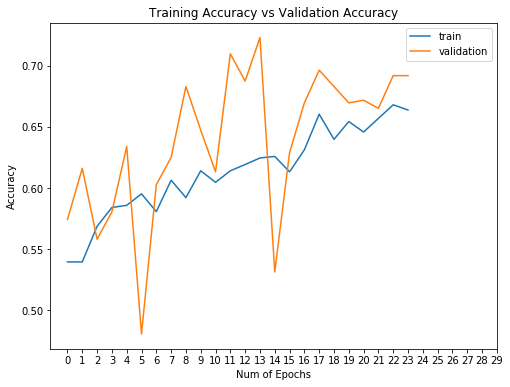

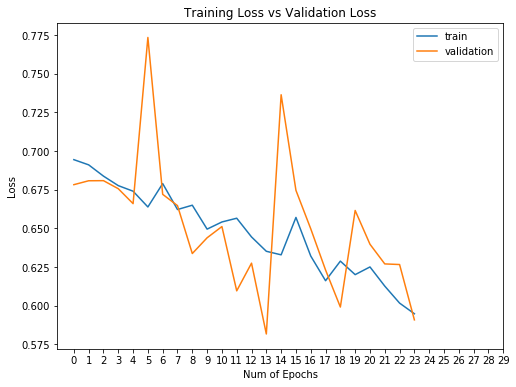

In [26]:
plt.figure(0)
plt.plot(hist_humerus.history['acc'],)
plt.plot(hist_humerus.history['val_acc'])
plt.xticks(np.arange(0, 30, 1))

plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(hist_humerus.history['loss'])
plt.plot(hist_humerus.history['val_loss'])
plt.xticks(np.arange(0, 30, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

For our built model the validation accuracy is higher than our training accuracy, which is likely due to the image augmentation technique which was imployed earlier. This is because the image augmentation was done on the training set and not the validation so our model achieves a better accuracy score on validation as it does not fit as well on the training. 

We have a peak accuracy of 72% on our validation and only 67% on our training. Unlike our wrist model, we do not see overfitting here. 

In [31]:
#reset our validation to prevent order change
valid_set_humerus.reset()

#predictions on validation
Y_pred = classifier.predict_generator(valid_set_humerus,288/64)
predicted_class_indices=[1 if x >= 0.5 else 0 for x in Y_pred]


Confusion Matrix


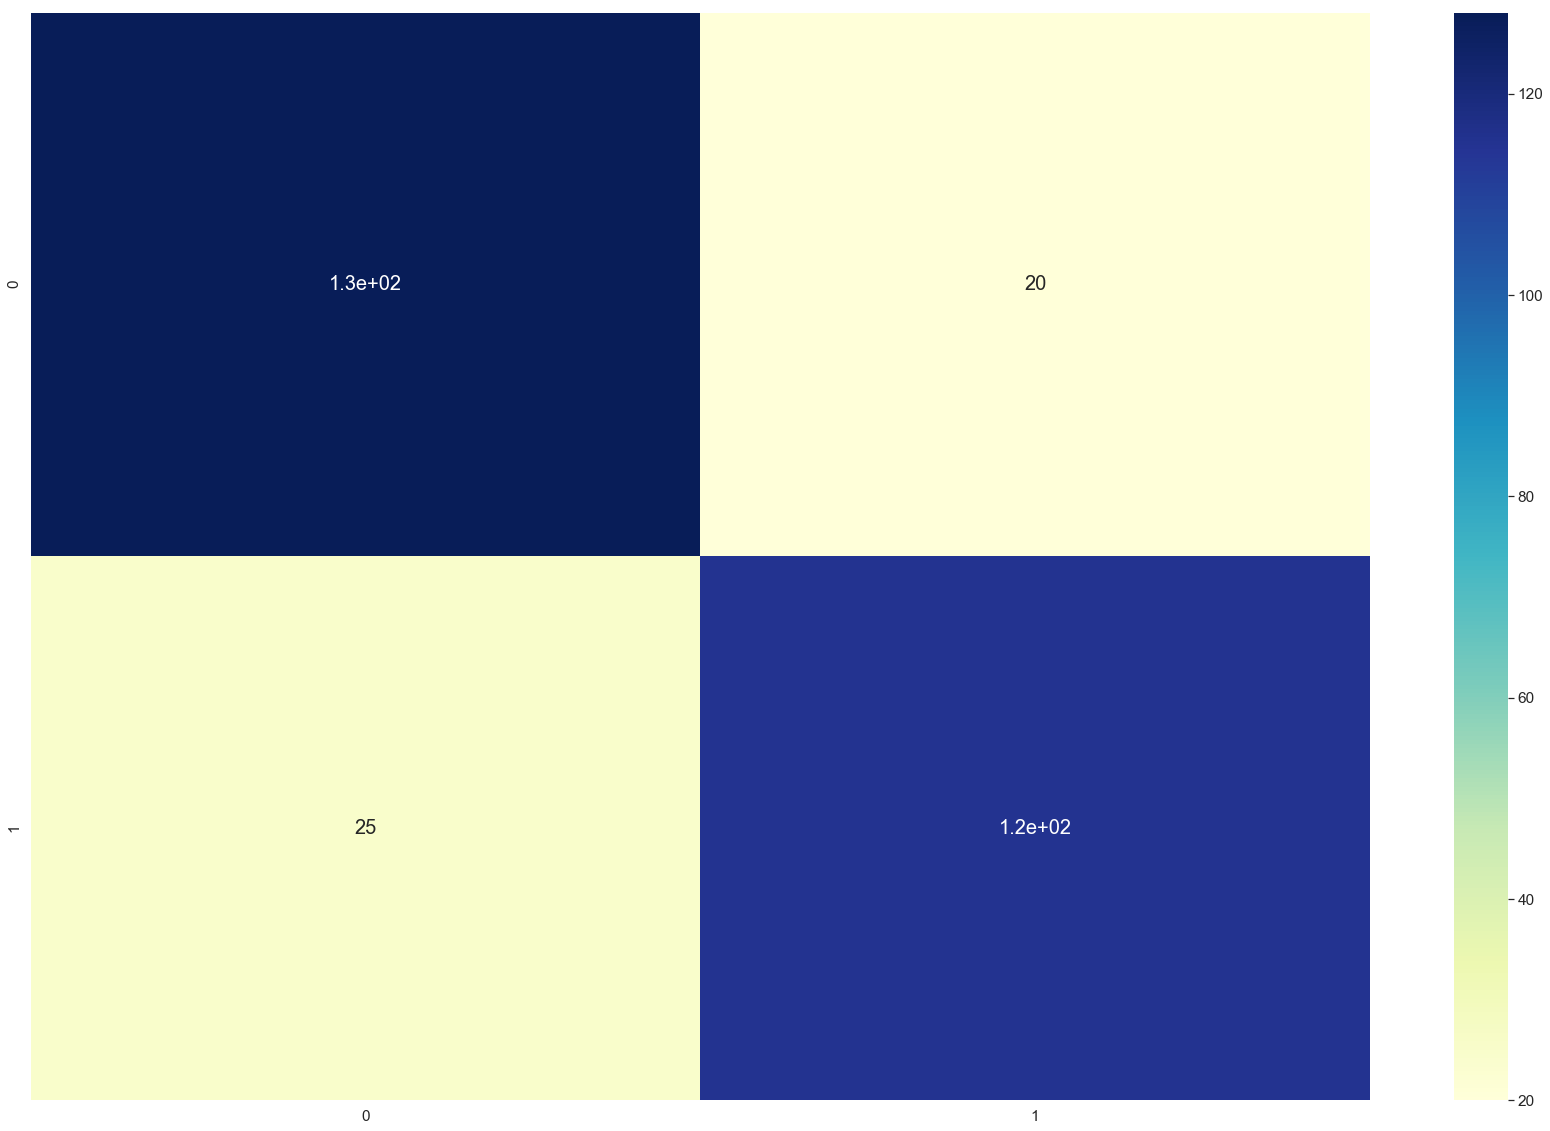

In [21]:
print('Confusion Matrix')
cm=confusion_matrix(valid_set_humerus.classes, predicted_class_indices)
plt.figure(figsize = (30,20))
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") 
plt.show()


From the confusion matrix above we can see that we accurately classify 96 negative/normal (0) X-rays as well as 97 positive/abnormal (1) X-rays. We misclassify 52 negative(0) X rays as abnormal, and 43 abnormal X-rays as normal.

In [33]:
cohen_kappa_score(predicted_class_indices,valid_set_humerus.classes)

0.340913470803623

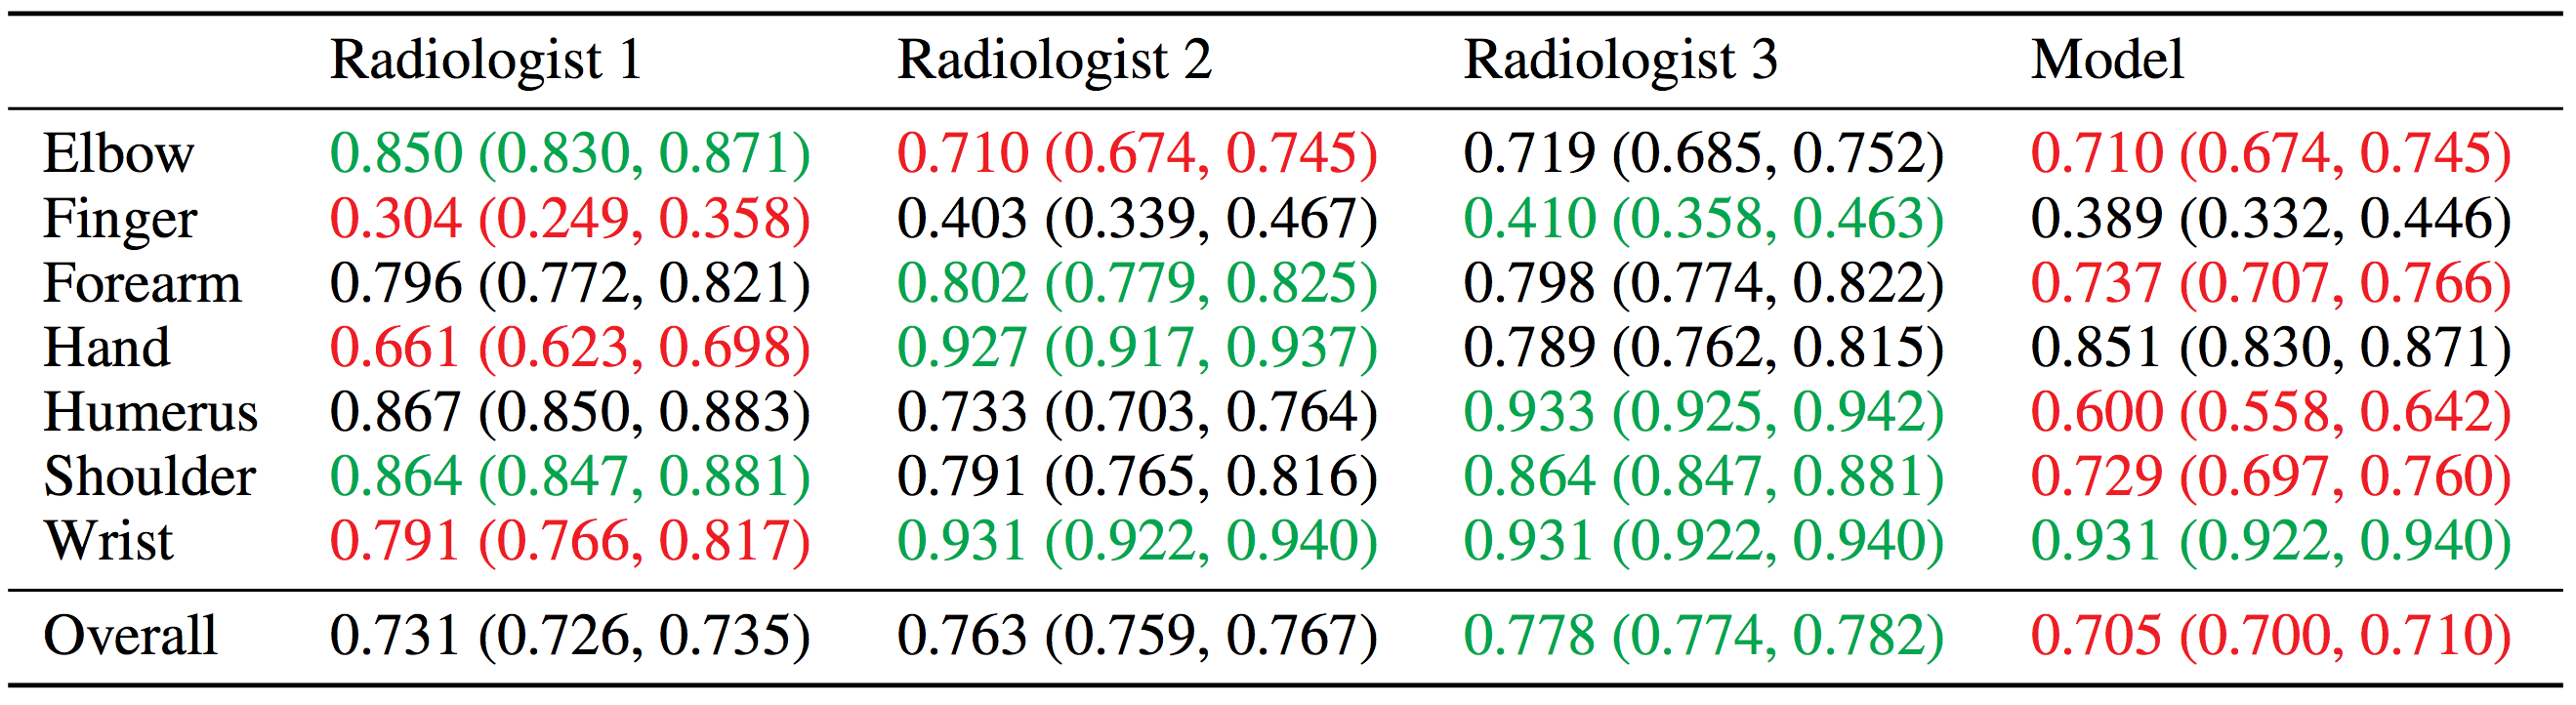

We compare our kappa score of 0.340 to the MURA study for humerus at 0.600. Again this is a significant yet not unexpected different as the model which they imployed is much more complex (169 layers).

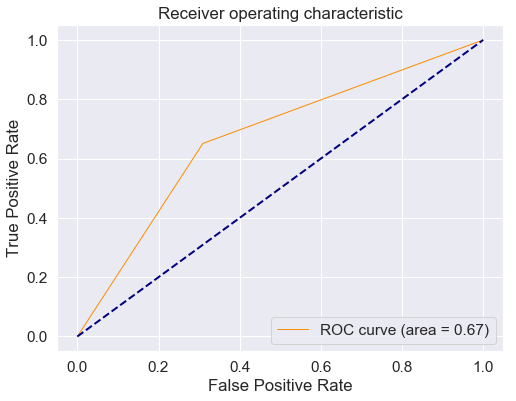

In [35]:
fpr, tpr, thresholds = roc_curve(predicted_class_indices, valid_set_humerus.classes)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In terms of our models ability to distiguish between the two classes (abnormal and normal), our built model only is capable of doign so 67% of the time.

#### Pre-built model

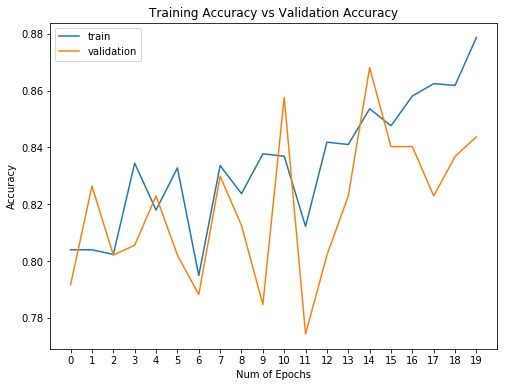

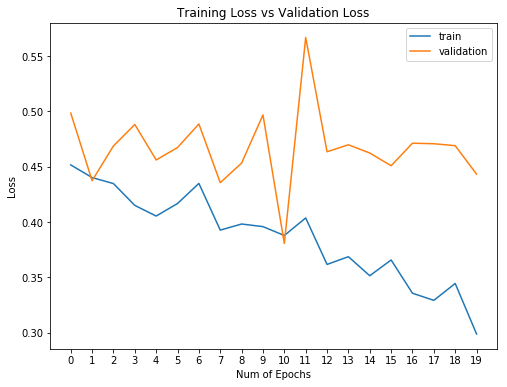

In [13]:
plt.figure(0)
plt.plot(hist_humerus2.history['acc'],)
plt.plot(hist_humerus2.history['val_acc'])
plt.xticks(np.arange(0, 20, 1))

plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(hist_humerus2.history['loss'])
plt.plot(hist_humerus2.history['val_loss'])
plt.xticks(np.arange(0, 20, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

Our pre-built model does much better in terms of  higher accuracy and lower loss compared to our built model. Our peak validation accuracy is  86.8% and our training accuracy is 87.89. These results are quite different from our built model as this pre-trained model seems to adapt better to the augmented images compared to our built model.

In [16]:
valid_set_humerus.reset()
Y_pred = classifier2.predict_generator(valid_set_humerus,288/16)
predicted_class_indices=[1 if x >= 0.5 else 0 for x in Y_pred]


Confusion Matrix


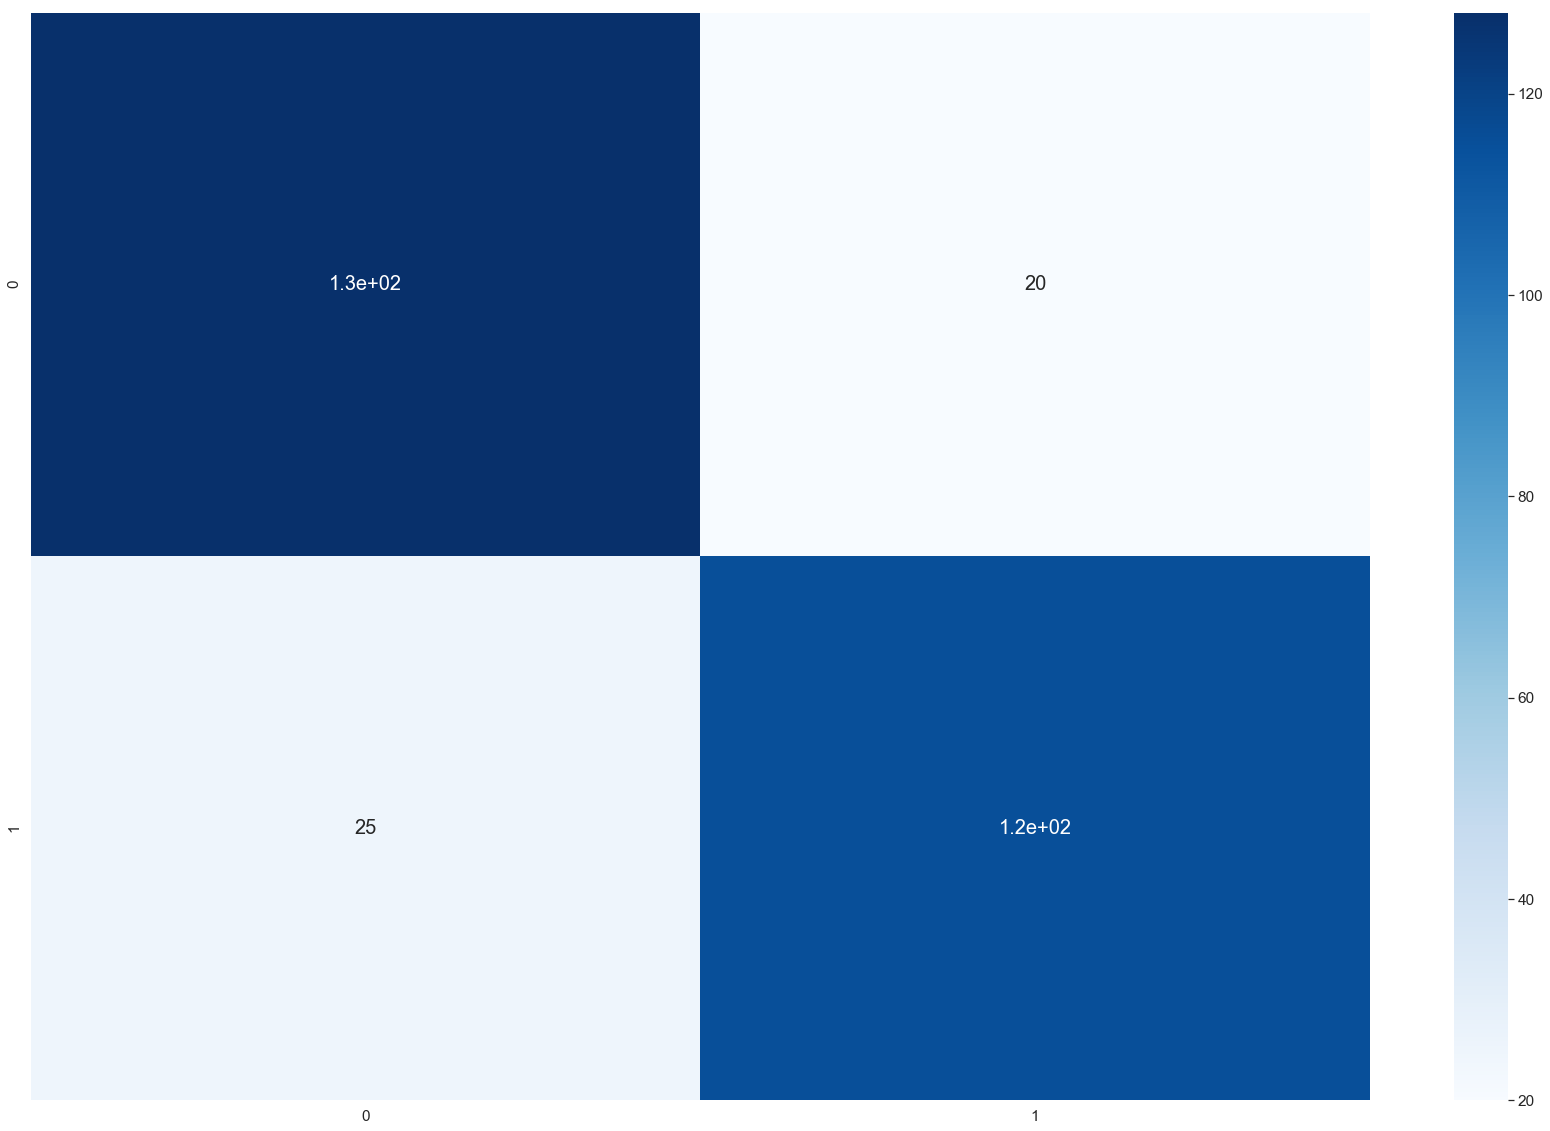

In [20]:
print('Confusion Matrix')
cm1=confusion_matrix(valid_set_humerus.classes, predicted_class_indices)
plt.figure(figsize = (30,20))
sn.heatmap(cm1, annot=True, annot_kws={"size": 20},cmap="Blues") 
plt.show()

From the confusion matrix above we can see that we accurately classify 130 negative/normal (0) X-rays as well as 120 positive/abnormal (1) X-rays. We misclassify 20 negative(0) X rays as abnormal, and 25 abnormal X-rays as normal, this is a major improvement over our misclassified values of 52 and 43 respectively for our built model






In [18]:
cohen_kappa_score(predicted_class_indices,valid_set_humerus.classes)

0.6869565217391305

Our kappa score is also much better than our built model at 0.686 and even manages to beat the Standfords kappa score of 0.600 !

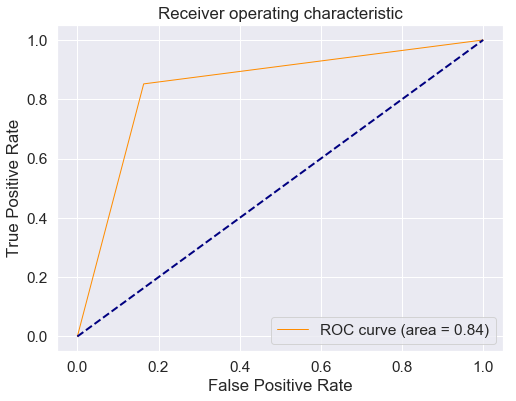

In [19]:
fpr, tpr, thresholds = roc_curve(predicted_class_indices, valid_set_humerus.classes)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

For the ROC graph above we can see that we have an AOC of 0.84 which means our model is capable of distiguishing between the abnormal and normal classes 84% of the time